In [1]:
#!pip install git+https://github.com/JoaquinAmatRodrigo/skforecast#master --upgrade
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(1, '/home/ximo/Documents/GitHub/skforecast')
%config Completer.use_jedi = False

In [2]:
!pip uninstall -y skforecast

In [16]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
import warnings

# Data

In [4]:
# Descarga de data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/Estadistica-machine-'
       'learning-python/master/data/bike_sharing_dataset_clean.csv')
data = pd.read_csv(url)
data['date_time'] = pd.to_datetime(data['date_time'], format='%Y-%m-%d %H:%M:%S')
data = data.set_index('date_time')
data = data.asfreq('H')
data = data.sort_index()
data = data[['temp', 'weather', 'users']]
data

temp weather  users
date_time                                
2011-01-01 00:00:00   9.84   clear   16.0
2011-01-01 01:00:00   9.02   clear   40.0
2011-01-01 02:00:00   9.02   clear   32.0
2011-01-01 03:00:00   9.84   clear   13.0
2011-01-01 04:00:00   9.84   clear    1.0
...                    ...     ...    ...
2012-12-31 19:00:00  10.66    mist  119.0
2012-12-31 20:00:00  10.66    mist   89.0
2012-12-31 21:00:00  10.66   clear   90.0
2012-12-31 22:00:00  10.66   clear   61.0
2012-12-31 23:00:00  10.66   clear   49.0

[17544 rows x 3 columns]

In [5]:
# Separación data train-val-test
# ==============================================================================
fin_train = '2012-03-31 23:59:00'
fin_validacion = '2012-08-31 23:59:00'
data_train = data.loc[: fin_train, :]
data_val   = data.loc[fin_train:fin_validacion, :]
data_test  = data.loc[fin_validacion:, :]

print(f"Fechas train      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Fechas validacion : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Fechas test       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Fechas train      : 2011-01-01 00:00:00 --- 2012-03-31 23:00:00  (n=10944)
Fechas validacion : 2012-04-01 00:00:00 --- 2012-08-31 23:00:00  (n=3672)
Fechas test       : 2012-09-01 00:00:00 --- 2012-12-31 23:00:00  (n=2928)


# ForecasterAutoreg

In [172]:
# Create pipeline
# ==============================================================================
cat_cols = ['weather']
num_cols = ['temp']

preprocessor = make_column_transformer(
                    (OneHotEncoder(), cat_cols),
                    (StandardScaler(), num_cols),
                    remainder = 'passthrough'
               )

pipe = make_pipeline(preprocessor, Ridge())
pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['weather']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['temp'])])),
                ('ridge', Ridge())])

In [265]:
# Create and fit forecaster
# ==============================================================================
lags = 24
forecaster = ForecasterAutoreg(
                    regressor = pipe,
                    lags = lags
                )

forecaster.fit(y=data_train['users'], exog=data_train[['temp', 'weather']])
forecaster.summary()

ForecasterAutoreg 
Regressor: Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['weather']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['temp'])])),
                ('ridge', Ridge())]) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Window size: 24 
Included exogenous: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['temp', 'weather'] 
Training range: [Timestamp('2011-01-01 00:00:00'), Timestamp('2012-03-31 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Scaled autoregressive features: True 
Regresso

In [266]:
forecaster.scaler

StandardScaler(copy=False)

In [267]:
X, y = forecaster.create_train_X_y(y=data_train['users'], exog=data_train[['temp', 'weather']])
X

scaled_lag_1 scaled_lag_2 scaled_lag_3 scaled_lag_4  \
date_time                                                                 
2011-01-02 00:00:00    -0.775926     -0.85466    -0.811558    -0.797094   
2011-01-02 01:00:00    -0.933619    -0.775816    -0.854563    -0.811429   
2011-01-02 02:00:00    -0.933619    -0.933504    -0.775721    -0.854432   
2011-01-02 03:00:00    -0.990962    -0.933504    -0.933404    -0.775592   
2011-01-02 04:00:00    -1.012465    -0.990845    -0.933404    -0.933272   
...                          ...          ...          ...          ...   
2012-03-31 19:00:00     1.388769     2.836667     2.779314     3.281078   
2012-03-31 20:00:00     0.980201     1.388807     2.836653      2.77937   
2012-03-31 21:00:00     0.435443     0.980252     1.388837     2.836708   
2012-03-31 22:00:00    -0.030468     0.435513     0.980294     1.388921   
2012-03-31 23:00:00     0.062714    -0.030383     0.435571     0.980387   

                    scaled_lag_5 scaled_lag_6 scaled_lag_7 scaled_lag_8  \
date_time                                                                 
2011-01-02 00:00:00    -0.789777    -0.803958    -0.574479    -0.387895   
2011-01-02 01:00:00    -0.796944    -0.789623     -0.80393    -0.574389   
2011-01-02 02:00:00    -0.811279     -0.79679    -0.789589    -0.803919   
2011-01-02 03:00:00    -0.854283    -0.811126     -0.79676    -0.789573   
2011-01-02 04:00:00    -0.775442    -0.854133      -0.8111    -0.796746   
...                          ...          ...          ...          ...   
2012-03-31 19:00:00     2.894253     3.518222     3.397884     2.266049   
2012-03-31 20:00:00     3.281291     2.894624     3.519779     3.399355   
2012-03-31 21:00:00     2.779575     3.281685     2.895961     3.521293   
2012-03-31 22:00:00     2.836914     2.779939     3.283158     2.897257   
2012-03-31 23:00:00     1.389105     2.837282     2.781235      3.28459   

                    scaled_lag_9 scaled_lag_10  ... scaled_lag_17  \
date_time                                       ...                 
2011-01-02 00:00:00    -0.265763     -0.294288  ...     -1.033599   
2011-01-02 01:00:00    -0.387761     -0.265571  ...     -0.997659   
2011-01-02 02:00:00    -0.574346     -0.387616  ...     -0.954531   
2011-01-02 03:00:00    -0.803989     -0.574272  ...     -0.796396   
2011-01-02 04:00:00    -0.789636     -0.804002  ...     -0.652636   
...                          ...           ...  ...           ...   
2012-03-31 19:00:00     1.191035      0.545665  ...     -0.559192   
2012-03-31 20:00:00     2.267487      1.191782  ...     -0.832336   
2012-03-31 21:00:00      3.40135      2.268644  ...     -0.997659   
2012-03-31 22:00:00     3.523348      3.402938  ...     -1.019223   
2012-03-31 23:00:00     2.899006      3.524983  ...     -0.889839   

                    scaled_lag_18 scaled_lag_19 scaled_lag_20 scaled_lag_21  \
date_time                                                                     
2011-01-02 00:00:00      -1.04076     -1.047942     -1.047932     -0.961656   
2011-01-02 01:00:00     -1.033572     -1.040754     -1.047932     -1.047909   
2011-01-02 02:00:00     -0.997632     -1.033566     -1.040745     -1.047909   
2011-01-02 03:00:00     -0.954505     -0.997627     -1.033557     -1.040722   
2011-01-02 04:00:00     -0.796371       -0.9545     -0.997618     -1.033534   
...                           ...           ...           ...           ...   
2012-03-31 19:00:00     -0.465728     -0.393845     -0.171016      0.044631   
2012-03-31 20:00:00     -0.559171     -0.465724     -0.393839     -0.171002   
2012-03-31 21:00:00     -0.832311     -0.559167     -0.465717     -0.393823   
2012-03-31 22:00:00     -0.997632     -0.832306     -0.559159     -0.465701   
2012-03-31 23:00:00     -1.019196     -0.997627     -0.832297     -0.559142   

                    scaled_lag_22 scaled_lag_23 scaled_lag_24   temp weather  
date_time                                                      

In [273]:
lags = 24
forecaster = ForecasterAutoreg(
                    regressor = LinearRegression(),
                    lags = lags,
                    scale_autoreg_features=True
                )

forecaster.fit(y=data_train['users'])
predictions = forecaster.predict(24)
predictions

2012-04-01 00:00:00     89.087006
2012-04-01 01:00:00     59.254429
2012-04-01 02:00:00     89.394452
2012-04-01 03:00:00     52.556946
2012-04-01 04:00:00     11.224609
2012-04-01 05:00:00     19.655152
2012-04-01 06:00:00     39.010704
2012-04-01 07:00:00     69.542397
2012-04-01 08:00:00    145.972777
2012-04-01 09:00:00    196.617551
2012-04-01 10:00:00    296.866069
2012-04-01 11:00:00    410.651560
2012-04-01 12:00:00    520.222702
2012-04-01 13:00:00    560.746533
2012-04-01 14:00:00    549.691261
2012-04-01 15:00:00    543.597978
2012-04-01 16:00:00    519.546135
2012-04-01 17:00:00    472.567187
2012-04-01 18:00:00    368.276259
2012-04-01 19:00:00    280.501245
2012-04-01 20:00:00    210.866510
2012-04-01 21:00:00    164.346665
2012-04-01 22:00:00    139.302096
2012-04-01 23:00:00    107.883606
Freq: H, Name: pred, dtype: float64

In [271]:
lags = 24
forecaster = ForecasterAutoreg(
                    regressor = LinearRegression(),
                    lags = lags,
                    scale_autoreg_features=False
                )

forecaster.fit(y=data_train['users'])
predictions = forecaster.predict(24)
predictions

2012-04-01 00:00:00     89.087006
2012-04-01 01:00:00     59.254429
2012-04-01 02:00:00     89.394452
2012-04-01 03:00:00     52.556946
2012-04-01 04:00:00     11.224609
2012-04-01 05:00:00     19.655152
2012-04-01 06:00:00     39.010704
2012-04-01 07:00:00     69.542397
2012-04-01 08:00:00    145.972777
2012-04-01 09:00:00    196.617551
2012-04-01 10:00:00    296.866069
2012-04-01 11:00:00    410.651560
2012-04-01 12:00:00    520.222702
2012-04-01 13:00:00    560.746533
2012-04-01 14:00:00    549.691261
2012-04-01 15:00:00    543.597978
2012-04-01 16:00:00    519.546135
2012-04-01 17:00:00    472.567187
2012-04-01 18:00:00    368.276259
2012-04-01 19:00:00    280.501245
2012-04-01 20:00:00    210.866510
2012-04-01 21:00:00    164.346665
2012-04-01 22:00:00    139.302096
2012-04-01 23:00:00    107.883606
Freq: H, Name: pred, dtype: float64

In [274]:
forecaster.get_coef()

feature        coef
0    scaled_lag_1  134.920415
1    scaled_lag_2  -59.148581
2    scaled_lag_3   14.432747
3    scaled_lag_4    4.706080
4    scaled_lag_5   -9.447345
5    scaled_lag_6    1.232838
6    scaled_lag_7    4.012632
7    scaled_lag_8  -31.682896
8    scaled_lag_9   50.650829
9   scaled_lag_10  -22.875213
10  scaled_lag_11   -5.481791
11  scaled_lag_12    6.033951
12  scaled_lag_13   -7.946142
13  scaled_lag_14    8.064951
14  scaled_lag_15   10.800363
15  scaled_lag_16  -35.493233
16  scaled_lag_17   36.475767
17  scaled_lag_18  -16.602915
18  scaled_lag_19    0.414591
19  scaled_lag_20    8.224964
20  scaled_lag_21   -4.762142
21  scaled_lag_22   -1.072623
22  scaled_lag_23   29.961814
23  scaled_lag_24   17.164841

In [ ]:
# Create and fit forecaster
# ==============================================================================
lags = 24
forecaster = ForecasterAutoreg(
                    regressor = Ridge(),
                    lags = lags
                )

forecaster.fit(y=data_train['users'])
predictions = forecaster.predict(24)
predictions

In [38]:
# Predict
# ==============================================================================
predictions = forecaster.predict(24, exog=data_test[['temp']])
predictions

2012-04-01 00:00:00     92.914514
2012-04-01 01:00:00     66.935425
2012-04-01 02:00:00     98.917890
2012-04-01 03:00:00     62.896104
2012-04-01 04:00:00     21.784647
2012-04-01 05:00:00     28.981526
2012-04-01 06:00:00     46.255657
2012-04-01 07:00:00     76.477903
2012-04-01 08:00:00    152.003423
2012-04-01 09:00:00    201.279548
2012-04-01 10:00:00    300.560203
2012-04-01 11:00:00    413.655703
2012-04-01 12:00:00    521.939233
2012-04-01 13:00:00    561.724426
2012-04-01 14:00:00    551.821262
2012-04-01 15:00:00    546.633434
2012-04-01 16:00:00    522.469193
2012-04-01 17:00:00    474.823547
2012-04-01 18:00:00    370.968009
2012-04-01 19:00:00    283.003732
2012-04-01 20:00:00    213.267137
2012-04-01 21:00:00    164.003463
2012-04-01 22:00:00    137.765423
2012-04-01 23:00:00    108.089682
Freq: H, Name: pred, dtype: float64

Test error (mse): 0.010454411313511013


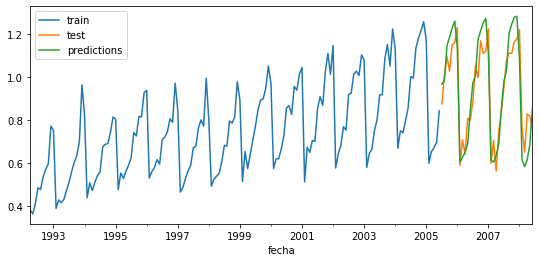

In [4]:
# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test.y,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data_train.y.plot(ax=ax, label='train')
data_test.y.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [11]:
# Grid search hiperparameters and lags
# ==============================================================================

# Regressor hiperparameters
param_grid ={'ridge__alpha': [0.01, 0.1, 1, 10]}

# lags used as predictors
lags_grid = [3, 10, [1,2,3,20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data_train.y,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 10,
                        metric      = 'mean_squared_error',
                        refit       = True,
                        initial_train_size = int(len(data_train)*0.5),
                        return_best = True,
                        verbose     = False
                    )

# Results grid search
# ==============================================================================
results_grid.head(4)

Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [00:00<00:00,  4.60it/s]


Refitting `forecaster` using the best found parameters and the whole data set: 
  lags: [ 1  2  3  4  5  6  7  8  9 10] 
  params: {'ridge__alpha': 1}



lags                  params    metric  \
6  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]     {'ridge__alpha': 1}  0.017812   
5  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]   {'ridge__alpha': 0.1}  0.017823   
4  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  {'ridge__alpha': 0.01}  0.017830   
7  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]    {'ridge__alpha': 10}  0.018637   

   ridge__alpha  
6          1.00  
5          0.10  
4          0.01  
7         10.00

In [12]:
# Predictors importance
# ==============================================================================
forecaster.get_coef()

feature      coef
0   lag_1  0.098111
1   lag_2 -0.034661
2   lag_3  0.029880
3   lag_4 -0.027202
4   lag_5  0.007476
5   lag_6 -0.021579
6   lag_7 -0.002423
7   lag_8 -0.003164
8   lag_9  0.012768
9  lag_10  0.021856

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 86
Number of observations used for backtesting: 109
    Number of folds: 4
    Number of steps per fold: 36
    Last fold only includes 1 observations

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1999-05-01 00:00:00
    Validation: 1999-06-01 00:00:00 -- 2002-05-01 00:00:00
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 1999-05-01 00:00:00
    Validation: 2002-06-01 00:00:00 -- 2005-05-01 00:00:00
Data partition in fold: 2
    Training:   1992-04-01 00:00:00 -- 1999-05-01 00:00:00
    Validation: 2005-06-01 00:00:00 -- 2008-05-01 00:00:00
Data partition in fold: 3
    Training:   1992-04-01 00:00:00 -- 1999-05-01 00:00:00
    Validation: 2008-06-01 00:00:00 -- 2008-06-01 00:00:00

[0.07695859]


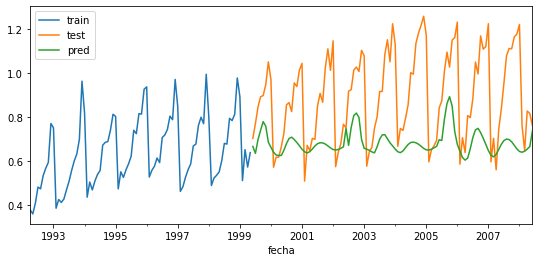

In [13]:
# Backtesting
# ==============================================================================
steps = 36
n_backtest = 36 * 3 + 1
data_train = data[:-n_backtest]
data_test  = data[-n_backtest:]

metrica, predicciones_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data.y,
                                    initial_train_size = len(data_train),
                                    steps      = steps,
                                    refit      = False,
                                    metric     = 'mean_squared_error',
                                    verbose    = True
                                )
print(metrica)

# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train.y.plot(ax=ax, label='train')
data_test.y.plot(ax=ax, label='test')
predicciones_backtest.plot(ax=ax, label='predictions')
ax.legend();

In [12]:
predicciones_backtest

pred
1999-06-01  0.674855
1999-07-01  0.635930
1999-08-01  0.700172
1999-09-01  0.741751
1999-10-01  0.780962
...              ...
2008-02-01  0.640887
2008-03-01  0.645681
2008-04-01  0.655776
2008-05-01  0.667460
2008-06-01  0.741560

[109 rows x 1 columns]

In [15]:
forecaster.fit(y=data_train.y)
predictions_1 = forecaster.predict(steps=steps)
predictions_2 = forecaster.predict(steps=steps, last_window=data_test.y[:steps])
predictions_3 = forecaster.predict(steps=steps, last_window=data_test.y[steps:steps*2])
predictions_4 = forecaster.predict(steps=1, last_window=data_test.y[steps*2:steps*3])
np.allclose(predicciones_backtest['pred'], np.concatenate([predictions_1, predictions_2, predictions_3, predictions_4]))

True

# ForecasterAutoreg with 1 exogenous variables

In [16]:
# Split train-test
# ==============================================================================
steps = 36
data_train = data.iloc[:-steps, :]
data_test  = data.iloc[-steps:, :]

In [17]:
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = lags
              )
forecaster

ForecasterAutoreg 
Regressor: Pipeline(steps=[('standardscaler', StandardScaler()), ('ridge', Ridge())]) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] 
Window size: 15 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'standardscaler__copy': True, 'standardscaler__with_mean': True, 'standardscaler__with_std': True, 'ridge__alpha': 1.0, 'ridge__copy_X': True, 'ridge__fit_intercept': True, 'ridge__max_iter': None, 'ridge__normalize': 'deprecated', 'ridge__positive': False, 'ridge__random_state': None, 'ridge__solver': 'auto', 'ridge__tol': 0.001} 
Creation date: 2021-12-13 01:06:08 
Last fit date: None 
Skforecast version: 0.4.0 

Test error (mse): 0.012636212003616849


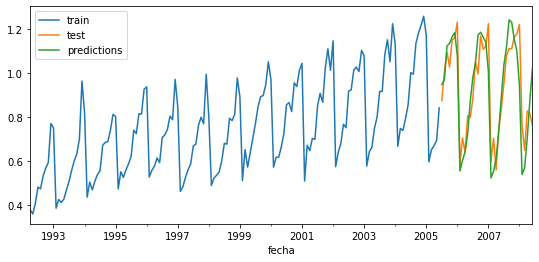

In [18]:
# Create and fit forecaster
# ==============================================================================
forecaster.fit(y=data_train.y, exog=data_train.exog_1)

# Predict
# ==============================================================================
steps = 36
predictions = forecaster.predict(steps=steps, exog=data_test.exog_1)

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data_train.y.plot(ax=ax, label='train')
data_test.y.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

# Error prediction
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test.y,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

In [13]:
# Grid search hiperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor= make_pipeline(StandardScaler(), RandomForestRegressor(random_state=123)),
                lags=12
             )

# Regressor hiperparameters
param_grid = {'randomforestregressor__n_estimators': [50, 100],
              'randomforestregressor__max_depth': [5, 10]}

# Lags used as predictors
lags_grid = [3, 10, [1,2,3,20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data_train.y,
                        exog        = data_train.exog_1,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 10,
                        metric      = 'mean_squared_error',
                        refit       = False,
                        initial_train_size = int(len(data_train)*0.5),
                        return_best = False,
                        verbose     = False
                    )

# Results grid Search
# ==============================================================================
results_grid.head(4)

Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [00:03<00:00,  1.19s/it]


lags  \
0                        [1, 2, 3]   
7  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]   
5  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]   
6  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]   

                                              params    metric  \
0  {'randomforestregressor__max_depth': 5, 'rando...  0.034116   
7  {'randomforestregressor__max_depth': 10, 'rand...  0.035796   
5  {'randomforestregressor__max_depth': 5, 'rando...  0.035851   
6  {'randomforestregressor__max_depth': 10, 'rand...  0.037176   

   randomforestregressor__max_depth  randomforestregressor__n_estimators  
0                                 5                                   50  
7                                10                                  100  
5                                 5                                  100  
6                                10                                   50

In [20]:
# Backtesting
# ==============================================================================
steps = 36
n_backtest = 36 * 3 + 1
data_train = data[:-n_backtest]
data_test  = data[-n_backtest:]

forecaster = ForecasterAutoreg(regressor=LinearRegression(), lags=10)

metrica, predicciones_backtest = backtesting_forecaster(
    forecaster = forecaster,
    y          = data.y,
    exog       = data.exog_1,
    initial_train_size = len(data_train),
    steps      = steps,
    metric     = 'mean_squared_error',
    verbose    = True
)

print(metrica)

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 86
Number of observations used for backtesting: 109
    Number of folds: 4
    Number of steps per fold: 36
    Last fold only includes 1 observations

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1999-05-01 00:00:00
    Validation: 1999-06-01 00:00:00 -- 2002-05-01 00:00:00
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 1999-05-01 00:00:00
    Validation: 2002-06-01 00:00:00 -- 2005-05-01 00:00:00
Data partition in fold: 2
    Training:   1992-04-01 00:00:00 -- 1999-05-01 00:00:00
    Validation: 2005-06-01 00:00:00 -- 2008-05-01 00:00:00
Data partition in fold: 3
    Training:   1992-04-01 00:00:00 -- 1999-05-01 00:00:00
    Validation: 2008-06-01 00:00:00 -- 2008-06-01 00:00:00

[6.21996921e-30]


In [21]:
# Verificar predicciones de backtesting
forecaster.fit(y=data_train.y, exog=data_train.exog_1)
predictions_1 = forecaster.predict(steps=steps, exog=data_test.exog_1[:steps])
predictions_2 = forecaster.predict(steps=steps, last_window=data_test.y[:steps], exog=data_test.exog_1[steps:steps*2])
predictions_3 = forecaster.predict(steps=steps, last_window=data_test.y[steps:steps*2], exog=data_test.exog_1[steps*2:steps*3])
predictions_4 = forecaster.predict(steps=1, last_window=data_test.y[steps*2:steps*3], exog=data_test.exog_1[steps*3:steps*4])
np.allclose(predicciones_backtest['pred'], np.concatenate([predictions_1, predictions_2, predictions_3, predictions_4]))

True

# ForecasterAutoreg with multiple exogenous variables

In [22]:
# Split train-test
# ==============================================================================
steps = 36
data_train = data.iloc[:-steps, :]
data_test  = data.iloc[-steps:, :]

In [23]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                    regressor = LinearRegression(),
                    lags      = 2
             )

forecaster.fit(y=data_train.y, exog=data_train[['exog_1', 'exog_2']])

forecaster

ForecasterAutoreg 
Regressor: LinearRegression() 
Lags: [1 2] 
Window size: 2 
Included exogenous: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['exog_1', 'exog_2'] 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': 'deprecated', 'positive': False} 
Creation date: 2021-12-13 01:06:57 
Last fit date: 2021-12-13 01:06:57 
Skforecast version: 0.4.0 

Test error (mse): 0.030285034610348982


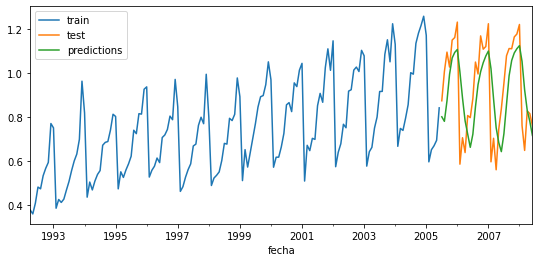

In [24]:
# Predict
# ==============================================================================
steps = 36
predictions = forecaster.predict(steps=steps, exog=data_test[['exog_1', 'exog_2']])

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data_train.y.plot(ax=ax, label='train')
data_test.y.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

# Error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test.y,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

In [25]:
# Grid search hiperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor=RandomForestRegressor(random_state=123),
                lags=12
             )

# Regressor hiperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10]}

# Lags used as predictors
lags_grid = [3, 10, [1,2,3,20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data_train['y'],
                        exog        = data_train[['exog_1', 'exog_2']],
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 10,
                        metric      = 'mean_squared_error',
                        refit       = False,
                        initial_train_size    = int(len(data_train)*0.5),
                        return_best = True,
                        verbose     = False
                    )

# Results grid Search
# ==============================================================================
results_grid

Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [00:07<00:00,  2.40s/it]

Refitting `forecaster` using the best found parameters and the whole data set: 
  lags: [ 1  2  3 20] 
  params: {'max_depth': 5, 'n_estimators': 50}



lags                                  params  \
8                     [1, 2, 3, 20]    {'max_depth': 5, 'n_estimators': 50}   
10                    [1, 2, 3, 20]   {'max_depth': 10, 'n_estimators': 50}   
9                     [1, 2, 3, 20]   {'max_depth': 5, 'n_estimators': 100}   
11                    [1, 2, 3, 20]  {'max_depth': 10, 'n_estimators': 100}   
3                         [1, 2, 3]  {'max_depth': 10, 'n_estimators': 100}   
1                         [1, 2, 3]   {'max_depth': 5, 'n_estimators': 100}   
4   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]    {'max_depth': 5, 'n_estimators': 50}   
0                         [1, 2, 3]    {'max_depth': 5, 'n_estimators': 50}   
5   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]   {'max_depth': 5, 'n_estimators': 100}   
2                         [1, 2, 3]   {'max_depth': 10, 'n_estimators': 50}   
7   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  {'max_depth': 10, 'n_estimators': 100}   
6   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]   {'max_depth': 10, 'n_estimators': 50}   

      metric  max_depth  n_estimators  
8   0.041572          5            50  
10  0.042374         10            50  
9   0.047357          5           100  
11  0.047655         10           100  
3   0.049627         10           100  
1   0.050294          5           100  
4   0.051669          5            50  
0   0.052149          5            50  
5   0.052404          5           100  
2   0.052786         10            50  
7   0.053234         10           100  
6   0.056936         10            50

# Unit Testing

In [20]:
# Unit test __init__
# ==============================================================================
import pytest
from pytest import approx
import numpy as np
import pandas as pd
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.linear_model import LinearRegression

def test_init_lags_when_integer():
    '''
    Test creation of attribute lags when integer is passed.
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=10)
    assert (forecaster.lags == np.arange(10) + 1).all()
    
def test_init_lags_when_list():
    '''
    Test creation of attribute lags when list is passed.
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=[1, 2, 3])
    assert (forecaster.lags == np.array([1, 2, 3])).all()
    
def test_init_lags_when_range():
    '''
    Test creation of attribute lags when range is passed.
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=range(1, 4))
    assert (forecaster.lags == np.array(range(1, 4))).all()
    
def test_init_lags_when_numpy_arange():
    '''
    Test creation of attribute lags when numpy arange is passed.
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=np.arange(1, 10))
    assert (forecaster.lags == np.arange(1, 10)).all()

def test_init_exception_when_lags_is_int_lower_than_1():
    '''
    Test exception is raised when lags is initialized with int lower than 1.
    '''
    with pytest.raises(Exception):
        ForecasterAutoreg(LinearRegression(), lags=-10)
        
def test_init_exception_when_lags_has_values_lower_than_1():
    '''
    Test exception is raised when lags is initialized with any value lower than 1.
    '''
    for lags in [[0, 1], range(0, 2), np.arange(0, 2)]:
        with pytest.raises(Exception):
            ForecasterAutoreg(LinearRegression(), lags=lags)

        
test_init_lags_when_integer()
test_init_lags_when_list() 
test_init_lags_when_range()
test_init_lags_when_numpy_arange()
test_init_exception_when_lags_is_int_lower_than_1()  
test_init_exception_when_lags_has_values_lower_than_1()

In [21]:
# Unit test _create_lags
# ==============================================================================
import pytest
from pytest import approx
import numpy as np
import pandas as pd
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.linear_model import LinearRegression


def test_create_lags_output():
    '''
    Test matrix of lags is created properly when langs=3 and y=np.arange(10).
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=3)
    results = forecaster._create_lags(y=np.arange(10))
    expected = (np.array([[2., 1., 0.],
                         [3., 2., 1.],
                         [4., 3., 2.],
                         [5., 4., 3.],
                         [6., 5., 4.],
                         [7., 6., 5.],
                         [8., 7., 6.]]),
               np.array([3., 4., 5., 6., 7., 8., 9.]))

    assert (results[0] == expected[0]).all()
    assert (results[1] == expected[1]).all()
    
    
def test_create_lags_exception_when_len_of_y_is_lower_than_maximum_lag():
    '''
    Test exception is raised when lenght of y is lower than maximum lag included
    in the forecaster.
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=10)
    with pytest.raises(Exception):
        forecaster._create_lags(y=np.arange(5))

test_create_lags_output()
test_create_lags_exception_when_len_of_y_is_lower_than_maximum_lag()

In [22]:
# Unit test create_train_X_y
# ==============================================================================
import pytest
from pytest import approx
import numpy as np
import pandas as pd
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.linear_model import LinearRegression


def test_create_train_X_y_output_when_y_is_series_10_and_exog_is_None():
    '''
    Test the output of create_train_X_y when y=pd.Series(np.arange(10)) and 
    exog is None.
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=5)
    results = forecaster.create_train_X_y(y=pd.Series(np.arange(10)))
    expected = (pd.DataFrame(
                    data = np.array([[4, 3, 2, 1, 0],
                                    [5, 4, 3, 2, 1],
                                    [6, 5, 4, 3, 2],
                                    [7, 6, 5, 4, 3],
                                    [8, 7, 6, 5, 4]]),
                    index   = np.array([5, 6, 7, 8, 9]),
                    columns = ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5']
                ),
                pd.Series(
                    np.array([5, 6, 7, 8, 9]),
                    index = np.array([5, 6, 7, 8, 9]))
               )     

    assert (results[0] == expected[0]).all().all()
    assert (results[1] == expected[1]).all()


def test_create_train_X_y_output_when_y_is_series_10_and_exog_is_series():
    '''
    Test the output of create_train_X_y when y=pd.Series(np.arange(10)) and 
    exog is a pandas series
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=5)
    results = forecaster.create_train_X_y(
                y = pd.Series(np.arange(10)),
                exog =  pd.Series(np.arange(100, 110), name='exog')
              )
    expected = (pd.DataFrame(
                    data = np.array([[4, 3, 2, 1, 0, 105],
                                    [5, 4, 3, 2, 1, 106],
                                    [6, 5, 4, 3, 2, 107],
                                    [7, 6, 5, 4, 3, 108],
                                    [8, 7, 6, 5, 4, 109]]),
                    index   = np.array([5, 6, 7, 8, 9]),
                    columns = ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'exog']
                ),
                pd.Series(
                    np.array([5, 6, 7, 8, 9]),
                    index = np.array([5, 6, 7, 8, 9]))
               )       

    assert (results[0] == expected[0]).all().all()
    assert (results[1] == expected[1]).all()

def test_create_train_X_y_output_when_y_is_series_10_and_exog_is_daraframe():
    '''
    Test the output of create_train_X_y when y=pd.Series(np.arange(10)) and 
    exog is a pandas dataframe with two columns.
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=5)
    results = forecaster.create_train_X_y(
                y = pd.Series(np.arange(10)),
                exog = pd.DataFrame({
                            'exog_1' : np.arange(100, 110),
                            'exog_2' : np.arange(1000, 1010)
                })
              )
        
    expected = (pd.DataFrame(
                    data = np.array([[4, 3, 2, 1, 0, 105, 1005],
                                  [5, 4, 3, 2, 1, 106, 1006],
                                  [6, 5, 4, 3, 2, 107, 1007],
                                  [7, 6, 5, 4, 3, 108, 1008],
                                  [8, 7, 6, 5, 4, 109, 1009]]),
                    index   = np.array([5, 6, 7, 8, 9]),
                    columns = ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'exog_1', 'exog_2']
                ),
                pd.Series(
                    np.array([5, 6, 7, 8, 9]),
                    index = np.array([5, 6, 7, 8, 9])
                )
               )        

    assert (results[0] == expected[0]).all().all()
    assert (results[1] == expected[1]).all()

def test_create_train_X_y_exception_when_y_and_exog_have_different_lenght():
    '''
    Test exception is raised when lenght of y and lenght of exog are different.
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=5)
    with pytest.raises(Exception):
        forecaster.fit(y=pd.Series(np.arange(50)), exog=pd.Series(np.arange(10)))
    with pytest.raises(Exception):
        forecaster.fit(y=pd.Series(np.arange(10)), exog=pd.Series(np.arange(50)))
    with pytest.raises(Exception):
        forecaster.fit(
            y=pd.Series(np.arange(10)),
            exog=pd.DataFrame(np.arange(50).reshape(25,2))
        )
        
def test_create_train_X_y_exception_when_y_and_exog_have_different_index():
    '''
    Test exception is raised when y and exog have diferent index.
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=5)
    with pytest.raises(Exception):
        forecaster.fit(
            y=pd.Series(np.arange(50)),
            exog=pd.Series(np.arange(10), index=np.arange(100, 110))
        )
           
test_create_train_X_y_output_when_y_is_series_10_and_exog_is_None()
test_create_train_X_y_output_when_y_is_series_10_and_exog_is_series()
test_create_train_X_y_output_when_y_is_series_10_and_exog_is_daraframe()
test_create_train_X_y_exception_when_y_and_exog_have_different_lenght()

/home/ximo/anaconda3/lib/python3.7/site-packages/skforecast/utils/utils.py:344: UserWarning: `exog` has DatetimeIndex index but no frequency. The index is overwritten with a RangeIndex.


In [23]:
# Unit test fit
# ==============================================================================
import pytest
from pytest import approx
import numpy as np
import pandas as pd
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.linear_model import LinearRegression

        
def test_fit_last_window_stored():
    '''
    Test that values of last window are stored after fitting.
    '''    
    forecaster = ForecasterAutoreg(LinearRegression(), lags=3)
    forecaster.fit(y=pd.Series(np.arange(50)))
    expected = pd.Series(np.array([47, 48, 49]), index=[47, 48, 49])
    assert (forecaster.last_window == expected).all()
    
    
def test_fit_in_sample_residuals_stored():
    '''
    Test that values of in_sample_residuals are stored after fitting.
    '''    
    forecaster = ForecasterAutoreg(LinearRegression(), lags=3)
    forecaster.fit(y=pd.Series(np.arange(5)))
    expected = np.array([0, 0])
    results = forecaster.in_sample_residuals  
    assert results.values == approx(expected)
    
test_fit_last_window_stored()
test_fit_in_sample_residuals_stored()

In [24]:
# Unit test _recursive_predict
# ==============================================================================
import pytest
from pytest import approx
import numpy as np
import pandas as pd
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.linear_model import LinearRegression

def test_recursive_predict_output_when_regresor_is_LinearRegression():
    '''
    Test _recursive_predict output when using LinearRegression as regressor.
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=3)
    forecaster.fit(y=pd.Series(np.arange(50)))
    predictions = forecaster._recursive_predict(
                    steps = 5,
                    last_window = forecaster.last_window.values,
                    exog = None
                  )
    expected = np.array([50., 51., 52., 53., 54.])
    assert (predictions == approx(expected))
    
test_recursive_predict_output_when_regresor_is_LinearRegression()

In [25]:
# Unit test predict
# ==============================================================================
from pytest import approx
import numpy as np
import pandas as pd
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.linear_model import LinearRegression

        
def test_predict_output_when_regresor_is_LinearRegression():
    '''
    Test predict output when using LinearRegression as regressor.
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=3)
    forecaster.fit(y=pd.Series(np.arange(50)))
    predictions = forecaster.predict(steps=5)
    expected = pd.Series(
                data = np.array([50., 51., 52., 53., 54.]),
                index = pd.RangeIndex(start=50, stop=55, step=1),
                name = 'pred'
               )
    pd.testing.assert_series_equal(predictions, expected)
    
test_predict_output_when_regresor_is_LinearRegression()

In [26]:
# Unit test get_coef
# ==============================================================================
from pytest import approx
import numpy as np
import pandas as pd
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor


def test_output_get_coef_when_regressor_is_LinearRegression():
    '''
    Test output of get_coef when regressor is LinearRegression with lags=3
    and it is trained with y=pd.Series(np.arange(5)).
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=3)
    forecaster.fit(y=pd.Series(np.arange(5)))
    expected = pd.DataFrame({
                    'feature': ['lag_1', 'lag_2', 'lag_3'],
                    'coef': np.array([0.33333333, 0.33333333, 0.33333333])
                })
    results = forecaster.get_coef()
    assert (results['feature'] == expected['feature']).all()
    assert results['coef'].values == approx(expected['coef'].values)
    
def test_output_get_coef_when_regressor_is_RandomForest():
    '''
    '''
    forecaster = ForecasterAutoreg(RandomForestRegressor(n_estimators=1, max_depth=2), lags=3)
    forecaster.fit(y=pd.Series(np.arange(5)))
    expected = None
    results = forecaster.get_coef()
    assert results is expected
    
test_output_get_coef_when_regressor_is_LinearRegression()
test_output_get_coef_when_regressor_is_RandomForest()

/home/ximo/anaconda3/lib/python3.7/site-packages/skforecast/ForecasterAutoreg/ForecasterAutoreg.py:897: UserWarning: `get_coef` only valid for forecasters with regressor of type (<class 'sklearn.linear_model._base.LinearRegression'>, <class 'sklearn.linear_model._coordinate_descent.Lasso'>, <class 'sklearn.linear_model._ridge.Ridge'>).


In [27]:
# Unit test get_feature_importance
# ==============================================================================
from pytest import approx
import numpy as np
import pandas as pd
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor


from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor

def test_output_get_feature_importance_when_regressor_is_RandomForest():
    forecaster = ForecasterAutoreg(RandomForestRegressor(n_estimators=1, max_depth=2, random_state=123), lags=3)
    forecaster.fit(y=pd.Series(np.arange(10)))
    expected = pd.DataFrame({
                    'feature': ['lag_1', 'lag_2', 'lag_3'],
                    'importance': np.array([0.94766355, 0., 0.05233645])
                })
    results = forecaster.get_feature_importance()
    assert (results['feature'] == expected['feature']).all()
    assert results['importance'].values == approx(expected['importance'].values)
    
    
def test_output_get_feature_importance_when_regressor_is_linear_model():
    forecaster = ForecasterAutoreg(Lasso(), lags=3)
    forecaster.fit(y=pd.Series(np.arange(5)))
    expected = None
    results = forecaster.get_feature_importance()
    assert results is expected
    
test_output_get_feature_importance_when_regressor_is_RandomForest()
test_output_get_feature_importance_when_regressor_is_linear_model()

/home/ximo/anaconda3/lib/python3.7/site-packages/skforecast/ForecasterAutoreg/ForecasterAutoreg.py:938: UserWarning: `get_feature_importance` only valid for forecasters with regressor of type (<class 'sklearn.ensemble._forest.RandomForestRegressor'>, <class 'sklearn.ensemble._gb.GradientBoostingRegressor'>, <class 'sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingRegressor'>).


In [28]:
# Unit test set_lags
# ==============================================================================
import pytest
import numpy as np
import pandas as pd
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.linear_model import LinearRegression


def test_set_lags_exception_when_lags_argument_is_int_lower_than_1():
    '''
    Test exception is raised when lags argument is lower than 1.
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=3)
    with pytest.raises(Exception):
        forecaster.set_lags(lags=-10)

def test_set_lags_exception_when_lags_argument_has_any_value_lower_than_1():
    '''
    Test exception is raised when lags argument has at least one value
    lower than 1.
    '''
    
    forecaster = ForecasterAutoreg(LinearRegression(), lags=3)
    with pytest.raises(Exception):
        forecaster.set_lags(lags=range(0, 4))        
        
def test_set_lags_when_lags_argument_is_int():
    '''
    Test how lags and max_lag attributes change when lags argument is integer
    positive (5).
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=3)
    forecaster.set_lags(lags=5)
    assert (forecaster.lags == np.array([1, 2, 3, 4, 5])).all()
    assert forecaster.max_lag == 5
    
def test_set_lags_when_lags_argument_is_list():
    '''
    Test how lags and max_lag attributes change when lags argument is a list
    of positive integers.
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=3)
    forecaster.set_lags(lags=[1,2,3])
    assert (forecaster.lags == np.array([1, 2, 3])).all()
    assert forecaster.max_lag == 3
    
def test_set_lags_when_lags_argument_is_1d_numpy_array():
    '''
    Test how lags and max_lag attributes change when lags argument is 1d numpy
    array of positive integers.
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=3)
    forecaster.set_lags(lags=np.array([1,2,3]))
    assert (forecaster.lags == np.array([1, 2, 3])).all()
    assert forecaster.max_lag == 3
    
test_set_lags_exception_when_lags_argument_is_int_lower_than_1()
test_set_lags_exception_when_lags_argument_has_any_value_lower_than_1()
test_set_lags_when_lags_argument_is_int()
test_set_lags_when_lags_argument_is_list()
test_set_lags_when_lags_argument_is_1d_numpy_array()

In [29]:
# Unit test set_params
# ==============================================================================
from pytest import approx
import numpy as np
import pandas as pd
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.linear_model import LinearRegression


def test_set_params():
    
    forecaster = ForecasterAutoreg(LinearRegression(fit_intercept=True), lags=3)
    new_paramns = {'fit_intercept': False}
    forecaster.set_params(**new_paramns)
    expected = {'copy_X': True,
                 'fit_intercept': False,
                 'n_jobs': None,
                 'normalize': 'deprecated',
                 'positive': False
                }
    results = forecaster.regressor.get_params()
    assert results == expected
    
test_set_params()

In [30]:
def test_set_params():
    
    forecaster = ForecasterAutoreg(LinearRegression(fit_intercept=True), lags=3)
    new_params = {'fit_intercept': False}
    forecaster.set_params(**new_params)
    expected = {'copy_X': True,
                 'fit_intercept': False,
                 'n_jobs': None,
                 'normalize': 'deprecated',
                 'positive': False
                }
    results = forecaster.regressor.get_params()
    assert results == expected
    
test_set_params()

In [31]:
# Unit test set_out_sample_residuals
# ==============================================================================
import pytest
from pytest import approx
import numpy as np
import pandas as pd
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.linear_model import LinearRegression


def test_set_out_sample_residuals_exception_when_residuals_is_not_array():
    '''
    Test exception is raised when residuals argument is not numpy array.
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=3)
    with pytest.raises(Exception):
        forecaster.set_out_sample_residuals(residuals=[1, 2, 3])
        
        
def test_set_out_sample_residuals_when_residuals_lenght_is_less_than_1000_and_no_append():
    '''
    Test residuals stored when its length is less than 1000 and append is False.
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=3)
    forecaster.set_out_sample_residuals(residuals=np.arange(10), append=False)
    expected = np.arange(10)
    results = forecaster.out_sample_residuals
    assert (results == expected).all()
    
def test_set_out_sample_residuals_when_residuals_lenght_is_less_than_1000_and_append():
    '''
    Test residuals stored when its length is less than 1000 and append is True.
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=3)
    forecaster.set_out_sample_residuals(residuals=np.arange(10), append=True)
    forecaster.set_out_sample_residuals(residuals=np.arange(10), append=True)
    expected = np.hstack([np.arange(10), np.arange(10)])
    results = forecaster.out_sample_residuals
    assert (results == expected).all()
    

def test_set_out_sample_residuals_when_residuals_lenght_is_greater_than_1000():
    '''
    Test residuals stored when its length is greater than 1000.
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=3)
    forecaster.set_out_sample_residuals(residuals=np.arange(2000))
    assert len(forecaster.out_sample_residuals) == 1000

test_set_out_sample_residuals_when_residuals_lenght_is_less_than_1000_and_no_append()
test_set_out_sample_residuals_when_residuals_lenght_is_less_than_1000_and_append()
test_set_out_sample_residuals_when_residuals_lenght_is_greater_than_1000()

In [32]:
# Unit test set_out_sample_residuals
# ==============================================================================
from pytest import approx
import numpy as np
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.linear_model import LinearRegression


def test_predict_interval_output_when_forecaster_is_LinearRegression_steps_is_1_in_sample_residuals_is_True():
    '''
    Test output when regressor is LinearRegression and one step ahead is predicted
    using in sample residuals.
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=3)
    forecaster.fit(y=pd.Series(np.arange(10)))
    forecaster.in_sample_residuals = np.full_like(forecaster.in_sample_residuals, fill_value=10)
    expected = pd.DataFrame(
                   np.array([[10., 20., 20.]]),
                   columns = ['pred', 'lower_bound', 'upper_bound'],
                   index = pd.RangeIndex(start=10, stop=11, step=1)
               )
    results = forecaster.predict_interval(steps=1, in_sample_residuals=True)  
    pd.testing.assert_frame_equal(results, expected)

    
def test_predict_interval_output_when_forecaster_is_LinearRegression_steps_is_2_in_sample_residuals_is_True():
    '''
    Test output when regressor is LinearRegression and two step ahead is predicted
    using in sample residuals.
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=3)
    forecaster.fit(y=pd.Series(np.arange(10)))
    forecaster.in_sample_residuals = np.full_like(forecaster.in_sample_residuals, fill_value=10)
    expected = pd.DataFrame(
                   np.array([[10. ,20., 20.],
                             [11., 24.33333333, 24.33333333]
                            ]),
                   columns = ['pred', 'lower_bound', 'upper_bound'],
                   index = pd.RangeIndex(start=10, stop=12, step=1)
               )
    results = forecaster.predict_interval(steps=2, in_sample_residuals=True)  
    pd.testing.assert_frame_equal(results, expected)
    
    
def test_predict_interval_output_when_forecaster_is_LinearRegression_steps_is_1_in_sample_residuals_is_False():
    '''
    Test output when regressor is LinearRegression and one step ahead is predicted
    using out sample residuals.
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=3)
    forecaster.fit(y=pd.Series(np.arange(10)))
    forecaster.out_sample_residuals = np.full_like(forecaster.in_sample_residuals, fill_value=10)
    expected = pd.DataFrame(
                   np.array([[10., 20., 20.]]),
                   columns = ['pred', 'lower_bound', 'upper_bound'],
                   index = pd.RangeIndex(start=10, stop=11, step=1)
               )
    results = forecaster.predict_interval(steps=1, in_sample_residuals=False)  
    pd.testing.assert_frame_equal(results, expected)
    
    
def test_predict_interval_output_when_forecaster_is_LinearRegression_steps_is_2_in_sample_residuals_is_False():
    '''
    Test output when regressor is LinearRegression and two step ahead is predicted
    using out sample residuals.
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=3)
    forecaster.fit(y=pd.Series(np.arange(10)))
    forecaster.out_sample_residuals = np.full_like(forecaster.in_sample_residuals, fill_value=10)
    expected = pd.DataFrame(
                   np.array([[10. ,20., 20.],
                             [11., 24.33333333, 24.33333333]
                            ]),
                   columns = ['pred', 'lower_bound', 'upper_bound'],
                   index = pd.RangeIndex(start=10, stop=12, step=1)
               )
    results = forecaster.predict_interval(steps=2, in_sample_residuals=False)  
    pd.testing.assert_frame_equal(results, expected)
    

test_predict_interval_output_when_forecaster_is_LinearRegression_steps_is_1_in_sample_residuals_is_True()
test_predict_interval_output_when_forecaster_is_LinearRegression_steps_is_2_in_sample_residuals_is_True()
test_predict_interval_output_when_forecaster_is_LinearRegression_steps_is_1_in_sample_residuals_is_False()
test_predict_interval_output_when_forecaster_is_LinearRegression_steps_is_2_in_sample_residuals_is_False()

In [33]:
# Unit test _estimate_boot_interval
# ==============================================================================
import pytest
from pytest import approx
import numpy as np
import pandas as pd
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.linear_model import LinearRegression
        

def test_estimate_boot_interval_output_when_forecaster_is_LinearRegression_steps_is_1_in_sample_residuals_is_True():
    '''
    Test output of _estimate_boot_interval when regressor is LinearRegression and
    1 step is predicted using in-sample residuals.
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=3)
    forecaster.fit(y=pd.Series(np.arange(10)))
    forecaster.in_sample_residuals = np.full_like(forecaster.in_sample_residuals, fill_value=10)
    expected = np.array([[20., 20.]])
    results = forecaster._estimate_boot_interval(steps=1, in_sample_residuals=True)  
    assert results == approx(expected)
    
    
def test_estimate_boot_interval_output_when_forecaster_is_LinearRegression_steps_is_2_in_sample_residuals_is_True():
    '''
    Test output of _estimate_boot_interval when regressor is LinearRegression and
    2 steps are predicted using in-sample residuals.
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=3)
    forecaster.fit(y=pd.Series(np.arange(10)))
    forecaster.in_sample_residuals = np.full_like(forecaster.in_sample_residuals, fill_value=10)
    expected = np.array([[20., 20.],
                        [24.33333333, 24.33333333]])
    results = forecaster._estimate_boot_interval(steps=2, in_sample_residuals=True)  
    assert results == approx(expected)
    
    
def test_estimate_boot_interval_output_when_forecaster_is_LinearRegression_steps_is_1_in_sample_residuals_is_False():
    '''
    Test output of _estimate_boot_interval when regressor is LinearRegression and
    1 step is predicted using out-sample residuals.
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=3)
    forecaster.fit(y=pd.Series(np.arange(10)))
    forecaster.out_sample_residuals = np.full_like(forecaster.in_sample_residuals, fill_value=10)
    expected = np.array([[20., 20.]])
    results = forecaster._estimate_boot_interval(steps=1, in_sample_residuals=False)  
    assert results == approx(expected)
    
    
def test_estimate_boot_interval_output_when_forecaster_is_LinearRegression_steps_is_2_in_sample_residuals_is_False():
    '''
    Test output of _estimate_boot_interval when regressor is LinearRegression and
    2 steps are predicted using out-sample residuals.
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=3)
    forecaster.fit(y=pd.Series(np.arange(10)))
    forecaster.out_sample_residuals = np.full_like(forecaster.in_sample_residuals, fill_value=10)
    expected = np.array([[20.        , 20.        ],
                        [24.33333333, 24.33333333]])
    results = forecaster._estimate_boot_interval(steps=2, in_sample_residuals=False)  
    assert results == approx(expected)
    
    
test_estimate_boot_interval_output_when_forecaster_is_LinearRegression_steps_is_1_in_sample_residuals_is_True()
test_estimate_boot_interval_output_when_forecaster_is_LinearRegression_steps_is_2_in_sample_residuals_is_True()
test_estimate_boot_interval_output_when_forecaster_is_LinearRegression_steps_is_1_in_sample_residuals_is_False()
test_estimate_boot_interval_output_when_forecaster_is_LinearRegression_steps_is_2_in_sample_residuals_is_False()

In [34]:
import session_info
session_info.show(html=False, write_req_file=False)

-----
matplotlib          3.4.3
numpy               1.19.5
pandas              1.2.5
pytest              6.2.4
session_info        1.0.0
skforecast          0.4.0
sklearn             1.0.1
-----
IPython             7.26.0
jupyter_client      6.1.7
jupyter_core        4.6.3
jupyterlab          2.1.3
notebook            6.4.0
-----
Python 3.7.9 (default, Aug 31 2020, 12:42:55) [GCC 7.3.0]
Linux-5.11.0-41-generic-x86_64-with-debian-bullseye-sid
-----
Session information updated at 2021-12-08 22:24
